# The Continuous bag of words model (CBOW)

- In continuous bag of words (CBOW) modeling, we try to predict the center word given a few context words (the words around the center word).
- For example, if we were to choose a context half-size of say $C = 2$, then we would try to predict the word **happy** given the context that includes 2 words before and 2 words after the center word:

> $C$ words before: [I, am] 

> $C$ words after: [because, I] 

- In other words:

$$context = [I,am, because, I]$$
$$target = happy$$

The structure of the model will look like this:

<div style="text-align:center;">
<img src='./media/word2.png' style="width:600px;height:250px;"><br>Figure 1. For single input data (non-batch).</div>

Where $\bar x$ is the average of all the one hot vectors of the context words. 

<div style="text-align:center;">
<img src='./media/mean_vec2.png' style="width:600px;height:250px;"><br>Figure 2</div>

Once encoding is done for all the context words, you can use $\bar x$ as the input to your model. 

The architecture you will be implementing is as follows:

\begin{align*}
 h &= W_1 \  X + b_1  \\
 a &= ReLU(h)   \\
 z &= W_2 \  a + b_2    \\
 \hat y &= softmax(z)   \\
\end{align*}

In [182]:
%reload_ext autoreload
%autoreload 2

import re
import emoji
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
from utils import (preprocess_data, get_word2ind_mapping_dict, relu, softmax,
                   get_center_context_words, get_batches, compute_pca)


### Load, tokenize and process the data

In [44]:
data = preprocess_data("./shakespeare.txt")
print("Some tokens in the data: ",data[:10])

Some tokens in the data:  ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend']


In [12]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20))   # print the 20 most frequent words and their freq.

Size of vocabulary:  5775
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


#### Mapping words to indices and indices to words


In [13]:
word2ind, ind2word = get_word2ind_mapping_dict(data)
print("First 5 elements in the word to indices dictionary: ", list(word2ind.items())[:5])
print("First 5 elements in the indices to word: ", list(ind2word.items())[:5])

First 5 elements in the word to indices dictionary:  [('.', 0), ('a', 1), ('abandon', 2), ('abed', 3), ('abhor', 4)]
First 5 elements in the indices to word:  [(0, '.'), (1, 'a'), (2, 'abandon'), (3, 'abed'), (4, 'abhor')]


# Training the CBOW Model
<div style="text-align:center;">
<img src='./media/cbow_model_dimensions_single_input.png' style="width:839;height:349;"><br>Figure 3. For single input data (non-batch).</div>
<br>
<div style="text-align:center;">
<img src='./media/cbow_batch.png' style="width:839;height:349;"><br>Figure 4. For batch input data.</div>

###  Initializing the model

**We will create model for handling batch input data so that we can use minibatch gradient descent.**

Initialize the two weight matrices and two bias vectors. 
- The first matrix ($W_1$) is of dimension $N \times V$,
  - where $V$ is the number of words in your vocabulary
  - $N$ is the dimension of your word vector.
- The second matrix ($W_2$) is of dimension $V \times N$. 
- Vector $b_1$ has dimensions $N\times 1$
- Vector $b_2$ has dimensions  $V\times 1$. 

In [14]:
def initialize_model(V, N, random_seed=1):
    """
    Randomly initialize the parameters of the CBOW model.

    Params:
    ----------
    V: int
        Number specifying the dimension of the vocabulary.
    N: int
        Number specifying the dimension of the embedding vector.

    Returns:
    ----------
    The parameters of the model, W1, W2, b1, b2.
    """
    np.random.seed(random_seed)
    W1 = np.random.rand(N,V)
    W2 = np.random.rand(V,N)
    b1 = np.random.rand(N,1)
    b2 = np.random.rand(V,1)
    return W1, W2, b1, b2


### Implement Forward Propagation.

\begin{align*}
 h &= W_1 \  X + b_1   \\
 a &= ReLU(h)   \\
 z &= W_2 \  a + b_2    \\
 \hat{Y} &= \text{softmax}(z)
\end{align*}

- The Rectified Linear Unit (ReLU) given by:
$$ReLU(h)=\max (0,h)$$

- Softmax Activation is given by,
$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }  $$

In [31]:
def forward_propogation(X, W1, W2, b1, b2):
    """
    Computes the forward propogation step of the model.

    Params:
    ---------
    X: array of dimension (V x m)
        The average one hot vector for the context words.
    W1, W2, b1, b2:  arrays
        The matrices and biases of the model to be learned.
    
    Returns:
    ----------
    Y_hat, h: array of dimension (V x m)
        The output values of the model.
    """
    h = np.dot(W1, X) + b1
    a = relu(h)
    z = np.dot(W2, a) + b2
    Y_hat = softmax(z)
    return Y_hat, h    

### Implement Cost Function
To calculate the loss of a batch of inputs, we compute the following: 

$$J_{batch} = -\frac{1}{m}\sum_{i = 1}^{m}\sum_{j = 1}^{V} y_j^{\ (i)} log \ \hat{y}_j^{\ (i)} $$

Vectorized Form: 
$$J_{batch} = -\frac{1}{m}\sum_{i = 1}^{m} \ \mathbf{1}_m \left ( Y^{\ (i)} \odot log \ \hat{Y}^{\ (i)} \right )$$

Note:
$\mathbf{1}_m = \left (1, 1, \dots 1 \right)$ is a $m$ row vector.

In [32]:
def compute_cost(Y, Y_hat):
    """
    Computes the cross-entropy loss of the model.

    Params:
    ----------
    Y: array of dimension (V x m)
        The batch ground truth values.
    Y_hat: array of dimension (V x m)
        The predicted batch output values of the model.

    Returns:
    cost: float
        The cross-entropy loss of the model.
    """
    m = Y.shape[1]
    cost = -1 / m * np.sum(np.sum(Y * np.log(Y_hat), axis=0, keepdims=True))
    return cost

### Backpropagation

The formulas for backpropagation are the following.

\begin{align*}
 \frac{\partial J_{batch}}{\partial \mathbf{W_1}} &= \frac{1}{m}\rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right )\mathbf{x}^\top \\
 \frac{\partial J_{batch}}{\partial \mathbf{W_2}} &= \frac{1}{m}(\mathbf{\hat{y}} - \mathbf{y})\mathbf{h^\top} \\
 \frac{\partial J_{batch}}{\partial \mathbf{b_1}} &= \frac{1}{m}\rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right ) \ \mathbf{1_m^\top} \\
 \frac{\partial J_{batch}}{\partial \mathbf{b_2}} &= \frac{1}{m}(\mathbf{\hat{y}} - \mathbf{y} ) \ \mathbf{1_m^\top}
\end{align*}

Note:
$\mathbf{1}_m = \left (1, 1, \dots 1 \right)$ is a $m$ row vector.
In code, we implement the effect of $\mathbf{1}_m^\top$ on a matrix $A$ using,
>np.sum(A, axis=1, keepdims=True)

In [121]:
def back_prop(X, Y, Y_hat, h, W1, W2, b1, b2):
    """
    Computes the gradients of the model parameters w.r.t. the cost functions.

    Params:
    ----------
    X: array of dimension (V x m)
        The average one hot vector for the context words.
    Y: array of dimension (V x m)
        The batch ground truth values.
    Y_hat: array of dimension (V x m)
        The predicted batch output values of the model.
    h: array of dimension (N x m)
        The hidden vector.
    W1, W2, b1, b2: arrays
        The matrices and biases of the model to be learned.

    Returns:
    ---------- 
    grad_W1, grad_W2, grad_b1, grad_b2: arrays
        The gradients of the model parameters.
    """
    m = X.shape[1]
    y_diff = Y_hat - Y
    grad_W1 = (1 / m) * np.dot(relu(np.dot(W2.T, y_diff)),X.T)
    grad_W2 = (1 / m) * np.dot(y_diff, h.T) 
    grad_b1 = (1 / m) * np.sum(relu(np.dot(W2.T, y_diff)), axis=1, keepdims=True)
    grad_b2 = (1 / m) * np.sum(y_diff, axis=1, keepdims=True)

    return grad_W1, grad_W2, grad_b1, grad_b2
      

### Mini-Batch Gradient descent

During the gradient descent phase, we update the weights and biases by subtracting $\alpha$ times the gradient from the original matrices and vectors, using the following formulas. Each update will occure after processing `batch_size` training samples.

\begin{align*}
 \mathbf{W_1} &:= \mathbf{W_1} - \alpha \frac{\partial J}{\partial \mathbf{W_1}} \\
 \mathbf{W_2} &:= \mathbf{W_2} - \alpha \frac{\partial J}{\partial \mathbf{W_2}} \\
 \mathbf{b_1} &:= \mathbf{b_1} - \alpha \frac{\partial J}{\partial \mathbf{b_1}} \\
 \mathbf{b_2} &:= \mathbf{b_2} - \alpha \frac{\partial J}{\partial \mathbf{b_2}} \\
\end{align*}

In [220]:
def mini_batch_gradient_descent(data, word2ind, N, V, C=2, iters=100, alpha=0.03, batch_size=128):
  """
  Updates the parameters of the CBOW model using gradient descent.
  
  Params:
  ----------
  data: str
    The text corpus on which the CBOW model will be trained.
  word2ind: dict
    The words to indices dictionary.
  N: int
    Dimension of the word embedding vector.  
  V: int
    Dimension of vocabulary.
  C: int
    The half context size.
  iters: int
    Specifies the number of mini-batch updates needed.
  alpha: float
    The learning hyperparameter.
  batch_size: int
    The number of samples from training data to consider for an update.
  
  Returns:
  ----------
  W1, W2, b1, b2:  arrays
    The updated model parameters. 
  """
  # Initialize the model parameters.
  W1, W2, b1, b2 = initialize_model(V, N, random_seed=282) 

  # List to capture the cost after every 50 gradient descent updates.
  cost_history = []

  count = 0

  # Generate batches of X and Y training data samples.
  for X, Y in get_batches(data, C, V, word2ind, batch_size=batch_size):

    # Get output values from the model.
    Y_hat, h = forward_propogation(X, W1, W2, b1, b2)

    if((count+1) % 50 == 0):
      # Capture cost of the model at current step.
      cost = compute_cost(Y, Y_hat)
      cost_history.append(cost)
      print(f'Cost after {count+1} gradient updates: {cost:.4f}')

    # Compute the gradients.
    grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(X, Y, Y_hat, h, W1, W2, b1, b2)

    # Update weights and biases
    W1 -= alpha*grad_W1 
    W2 -= alpha*grad_W2
    b1 -= alpha*grad_b1
    b2 -= alpha*grad_b2

    count += 1
    if count == iters:
      break
      
  # Return updated parameters of the model.
  return W1, W2, b1, b2, cost_history

In [231]:
W1, W2, b1, b2, cost_history = mini_batch_gradient_descent(data,
                                                           word2ind, 
                                                           N=50, 
                                                           V=len(word2ind), 
                                                           C=3, 
                                                           iters=500, 
                                                           alpha=9e-1, 
                                                           batch_size=128)

Cost after 50 gradient updates: 7.9091
Cost after 100 gradient updates: 7.4395
Cost after 150 gradient updates: 7.5127
Cost after 200 gradient updates: 7.3845
Cost after 250 gradient updates: 6.8268
Cost after 300 gradient updates: 6.8472
Cost after 350 gradient updates: 6.2466
Cost after 400 gradient updates: 6.1383
Cost after 450 gradient updates: 7.0776
Cost after 500 gradient updates: 6.5591


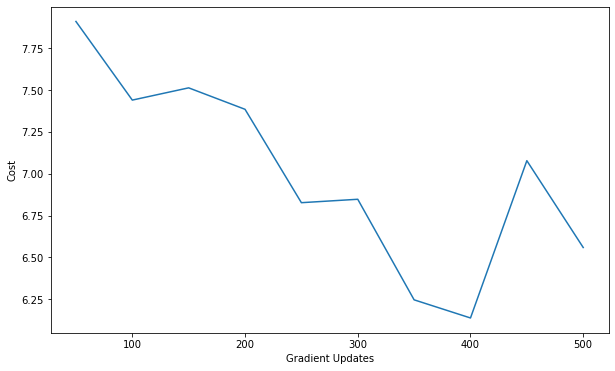

In [232]:
plt.figure(figsize=(10,6))
epochs = [i for i in range(50,501, 50)]
plt.plot(epochs, cost_history)
plt.xlabel('Gradient Updates')
plt.ylabel('Cost')
plt.show()

In [227]:
# visualizing the word vectors here
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

# embs = (W1.T + W2)/2.0
embs = W1.T
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [2744, 3949, 2960, 3022, 5672, 1452, 5671, 4189, 2315, 4276]


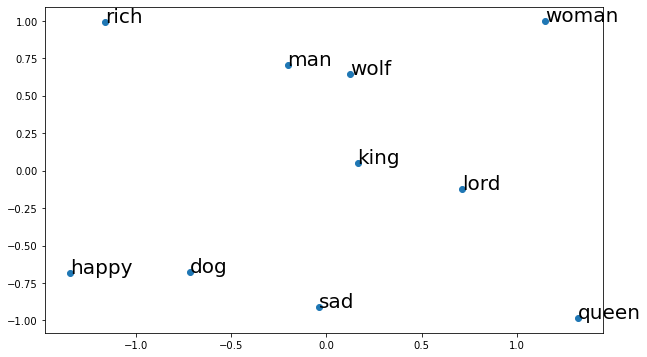

In [228]:
plt.figure(figsize=(10,6))
result= compute_pca(X, 2)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=20)
plt.show()